## Muthu Palaniappan M - IVP Lab Practical 21011101079

### Importing Packages

In [2]:
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import cv2
import os, random
import matplotlib.pyplot as plt
%matplotlib inline

K.set_image_data_format('channels_last')

### Defining Directory

In [3]:
DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'

train_dir = os.path.join(DATA_DIR, 'train')
mask_dir = os.path.join(DATA_DIR, 'train_labels')
val_dir = os.path.join(DATA_DIR, 'val')
v_mask_dir = os.path.join(DATA_DIR, 'val_labels')

test_dir = os.path.join(DATA_DIR, 'test')
t_mask_dir = os.path.join(DATA_DIR, 'test_labels')

### Helper Function

In [4]:
def preprocess_mask_image2(image, class_num, color_limit):
  pic = np.array(image)
  img = np.zeros((pic.shape[0], pic.shape[1], 1))
  np.place(img[ :, :, 0], pic[ :, :, 0] >= color_limit, 1)
  return img

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) / 2

    if padding<0:
        return image

    return image[padding:image_size - padding, padding:image_size - padding, :]

#Generator for training
def train_generator(img_dir, label_dir, batch_size, input_size, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = os.path.join(img_dir, list_images[id] + 'f')
              mask_name = os.path.join(label_dir, list_images[id])


              img = cv2.imread(img_name)
              img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)

              x_batch += [img]
              y_batch += [mask]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)
            
#generate the batch elements whitout the outliers
def train_generator_vs2(img_dir, label_dir, batch_size, input_size, outliers_list, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
                
              if list_images[id].split('.')[0] not in outliers_list:
                  img_name = os.path.join(img_dir, list_images[id] + 'f')
                  mask_name = os.path.join(label_dir, list_images[id])

                  img = cv2.imread(img_name)
                  img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

                  mask = cv2.imread(mask_name)
                  mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
                  mask = preprocess_mask_image2(mask, 2, 50)

                  x_batch += [img]
                  y_batch += [mask]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)
            
#Generator for test phase
def test_generator(img_dir, label_dir, batch_size, input_size, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = os.path.join(img_dir,list_images[id]+'f')
              mask_name = os.path.join(label_dir, list_images[id])

              img = cv2.imread(img_name)
              img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)

              x_batch += [img]
              y_batch += [mask[:,:,0]]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)
            
            
#Resize and normalize the test img
def prepare_test_image(image):
  x_batch = []
  # img = cv2.imread(image_path)
  img  = cv2.resize(image, image_shape, interpolation=cv2.INTER_AREA)
  x_batch += [img]
  x_batch = np.array(x_batch) / 255.

  return x_batch

#Convert an image to binary
def binaryImage(image):
  x = image.shape[1]
  y = image.shape[2]
  imgs = np.zeros((x,y,3))
  for k in range(x):
    for n in range(y):
      if image[0,k,n]>0.5:
        imgs[k,n,0]=255
        imgs[k,n,1]=255
        imgs[k,n,2]=255
        # print(imgs[k,n])
      # else:
      #   imgs[k,n]=0
  return imgs

#Draw Function
def draw(orig_im, mask_im, recogn_im, out_im):
  plt.figure(figsize=(20,17))
  plt.subplot(1,4,1)
  plt.title('Original')
  plt.imshow(orig_im)
  plt.subplot(1,4,2)
  plt.title('Mask Original')
  plt.imshow(mask_im)
  plt.subplot(1,4,3)
  plt.title('Recogn Roads')
  plt.imshow(recogn_im)
  plt.subplot(1,4,4)
  plt.title('Out Unet')
  plt.imshow(out_im)
  plt.axis('off')
  plt.show()

#Prediction with test images
def recogn_test_image(p_dataset = 1):
  test_images = os.listdir(t_mask_dir)
  nr_samples = int(len(test_images)*p_dataset)

  # Selecionar N números aleatórios sem repetição da lista
  test_sample = random.sample(test_images, nr_samples)
  
  for test in test_sample:
    im_test = cv2.imread(os.path.join(test_dir,test+'f'))
    im_mask = cv2.imread(os.path.join(t_mask_dir,test))
    out_test = model.predict(prepare_test_image(im_test), verbose=0)
    img_r = binaryImage(out_test)
    draw(im_test, im_mask, img_r, out_test[0,:, :, 0]*255)

### Defining Hyperparameters

In [10]:
#Hyperparameters
batch_size = 2
LR = 0.0001
Optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LR)
#Optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
#Optimizer = 'Adam'
#Optimizer = 'SGD'

Loss_FN = dice_coef_loss
#Loss_FN = 'binary_crossentropy'

Epochs = 10
Perc_DS = 0.1

#Steps per Epoch:
X_train = os.listdir(train_dir)
#SPE = 3*((len(X_train))*Perc_DS)/batch_size
SPE = (len(X_train)*Perc_DS)/batch_size

Act_Fn = 'relu'
#Act_Fn = 'softmax'
#Act_Fn = 'sigmoid'

#Knl = 3
#MxP = (2,2)

IMG_HEIGHT = 1024
IMG_WIDTH  = 1024
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
image_shape = (IMG_HEIGHT, IMG_WIDTH)



In [11]:
Outliers = []
#Outliers = ['18628885_15','25529170_15','17128960_15','18178825_15','17278780_15','25829290_15','18028825_15','26878675_15','24479110_15', '16228960_15','10078750_15','16828900_15','15628855_15','11278945_15','21329050_15','15928885_15','26578780_15','27028675_15','15778885_15','27178705_15','23129110_15','26728780_15','24628900_15','19228750_15','15778870_15']

### U-NET Model Definition

In [12]:
#Define U-Net por blocos
def conv_block(input, num_filters, act_fn, knl):
    x = Conv2D(num_filters, knl, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation(act_fn)(x)
    #x = Activation("relu")(x)

    x = Conv2D(num_filters, knl, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation(act_fn)(x)
    #x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters, MxP, act_fn, knl):
    x = conv_block(input, num_filters, act_fn, knl)
    p = MaxPooling2D(MxP)(x)
    #p = MaxPooling2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters, act_fn, knl):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, act_fn, knl)
    return x

#Build Unet using the blocks
#Canonical UNet, with four blocks of encoders and four blocks of decoders
def UNet_Canonical(input_shape, MxP, act_fn, knl):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64, MxP, act_fn, knl)
    s2, p2 = encoder_block(p1, 128, MxP, act_fn, knl)
    s3, p3 = encoder_block(p2, 256, MxP, act_fn, knl)
    s4, p4 = encoder_block(p3, 512, MxP, act_fn, knl)

    b1 = conv_block(p4, 1024, act_fn, knl) #Bridge

    d1 = decoder_block(b1, s4, 512, act_fn, knl)
    d2 = decoder_block(d1, s3, 256, act_fn, knl)
    d3 = decoder_block(d2, s2, 128, act_fn, knl)
    d4 = decoder_block(d3, s1, 64, act_fn, knl)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


#Deeper UNet, with five blocks of encoders and five blocks of decoders
def UNet_5(input_shape, MxP, act_fn, knl):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64, MxP, act_fn, knl)
    s2, p2 = encoder_block(p1, 128, MxP, act_fn, knl)
    s3, p3 = encoder_block(p2, 256, MxP, act_fn, knl)
    s4, p4 = encoder_block(p3, 512, MxP, act_fn, knl)
    s5, p5 = encoder_block(p4, 1024, MxP, act_fn, knl)

    b1 = conv_block(p5, 2048, act_fn, knl) #Bridge

    d1 = decoder_block(b1, s5, 1024, act_fn, knl)
    d2 = decoder_block(d1, s4, 512, act_fn, knl)
    d3 = decoder_block(d2, s3, 256, act_fn, knl)
    d4 = decoder_block(d3, s2, 128, act_fn, knl)
    d5 = decoder_block(d4, s1, 64, act_fn, knl)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

#UNET for 1024 x 1024 imgs
def UNet(act_fn, num_classes = 1, input_shape= (image_shape[0],image_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
 #bridge
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation(act_fn)(x)
  #Up1
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(inputs=inp, outputs=x)

    # model.summary()
  return model

#UNET whith 5 layers
def UNet_vs2(act_fn, num_classes = 1, input_shape= (image_shape[0],image_shape[1], 3)):
#def UNet_vs2(num_classes = 1, input_shape= (image_shape[0],image_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation(act_fn)(x)
  x = MaxPooling2D()(block_4_out)

  # Bridge
  x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)
  x = BatchNormalization()(x)
  block_5_out = Activation(act_fn)(x)

  #UP 1
  x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP1')(block_5_out)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_4_out])
  x = Conv2D(512, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(512, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  UP1_out = Activation(act_fn)(x)

  #UP 2
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(UP1_out)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  UP2_out = Activation(act_fn)(x)

  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(UP2_out)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  UP3_out = Activation(act_fn)(x)

  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(UP3_out)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(act_fn)(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  UP4_out = Activation(act_fn)(x)

  #Final Convolution and activation
  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(UP4_out)

  model = Model(inputs=inp, outputs=x)

    # model.summary()
  return model

### Compile Model

In [13]:
model = UNet(Act_Fn)
#model = UNet_vs2(Act_Fn)

# compile the model
model.compile(optimizer=Optimizer, loss=Loss_FN, metrics=['acc',f1_m,precision_m, recall_m])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
#model.compile(optimizer=Optimizer, loss=Loss_FN, metrics=[dice_coef])
#adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 1024, 1024,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_19 (BatchN  (None, 1024, 1024,   256        ['block1_conv1[0][0]']           
 ormalization)                  64)                                                         

### Model Training

In [14]:
#Training the model

if Outliers != []:

    history = model.fit(train_generator(train_dir, mask_dir, batch_size, input_shape, Perc_DS),
                        steps_per_epoch=SPE,
                        epochs=Epochs,
                        verbose=1,
                        # callbacks=callbacks,
                        validation_data=train_generator(val_dir, v_mask_dir, batch_size, input_shape, Perc_DS),
                        validation_steps=1,
                        class_weight=None,
                        max_queue_size=10,
                        workers=1
                       )

else:
    history = model.fit(train_generator_vs2(train_dir, mask_dir, batch_size, input_shape, Outliers, Perc_DS),
                        steps_per_epoch=SPE,
                        epochs=Epochs,
                        verbose=1,
                        # callbacks=callbacks,
                        validation_data=train_generator(val_dir, v_mask_dir, batch_size, input_shape, Perc_DS),
                        validation_steps=1,
                        class_weight=None,
                        max_queue_size=10,
                        workers=1
                        )

Epoch 1/10
55/55 [==============================] - 49s 850ms/step - loss: 0.3318 - acc: 0.9084 - f1_m: 0.0494 - precision_m: 0.1447 - recall_m: 0.0707 - val_loss: 0.5882 - val_acc: 0.8659 - val_f1_m: 4.5484e-04 - val_precision_m: 0.1684 - val_recall_m: 2.2773e-04
Epoch 2/10
55/55 [==============================] - 47s 840ms/step - loss: 0.2096 - acc: 0.9373 - f1_m: 0.0337 - precision_m: 0.3385 - recall_m: 0.0191 - val_loss: 0.4922 - val_acc: 0.8660 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
55/55 [==============================] - 47s 840ms/step - loss: 0.1887 - acc: 0.9392 - f1_m: 0.1224 - precision_m: 0.5208 - recall_m: 0.0769 - val_loss: 0.4255 - val_acc: 0.8660 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/10
55/55 [==============================] - 47s 840ms/step - loss: 0.1788 - acc: 0.9410 - f1_m: 0.2500 - precision_m: 0.5965 - recall_m: 0.1773 - val_loss: 0.4080 - val_acc: 0.8660 - val_f1

### Ploting the Training Grpah - Metrics

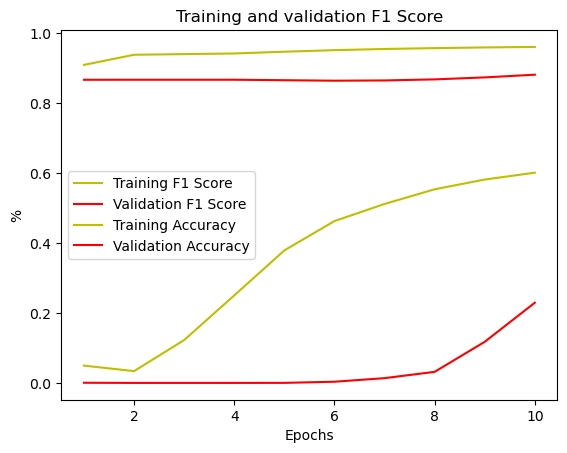

In [15]:
#plot the training and validation F1-Score and Accuracy at each epoch
f1_m = history.history['f1_m']
val_f1_m = history.history['val_f1_m']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(f1_m) + 1)


plt.plot(epochs, f1_m, 'y', label='Training F1 Score')
plt.plot(epochs, val_f1_m, 'r', label='Validation F1 Score')
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')


plt.title('Training and validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.show()

### Model Prediction

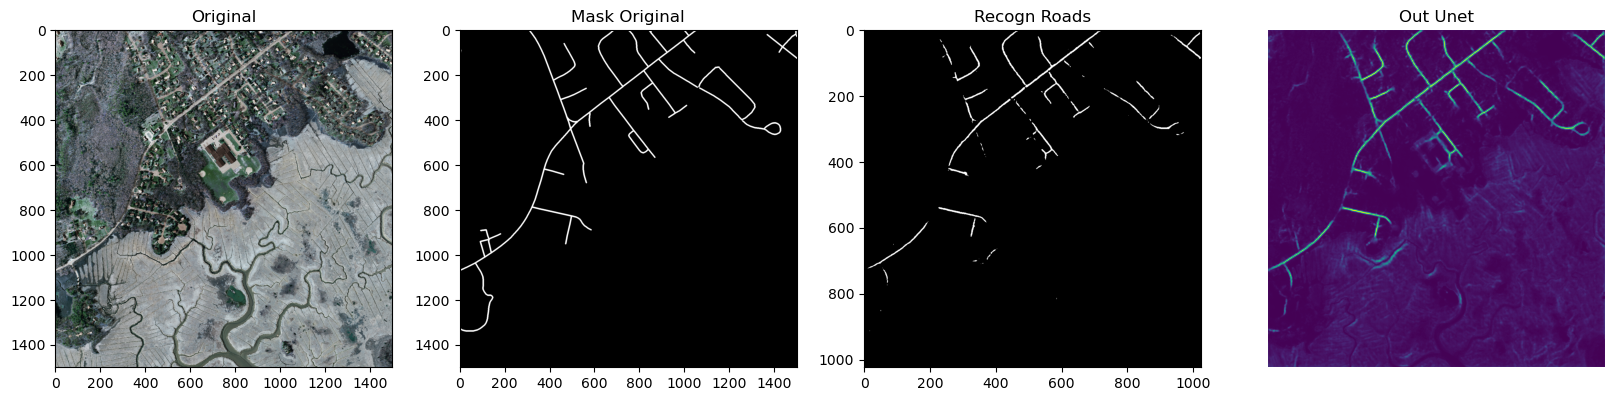

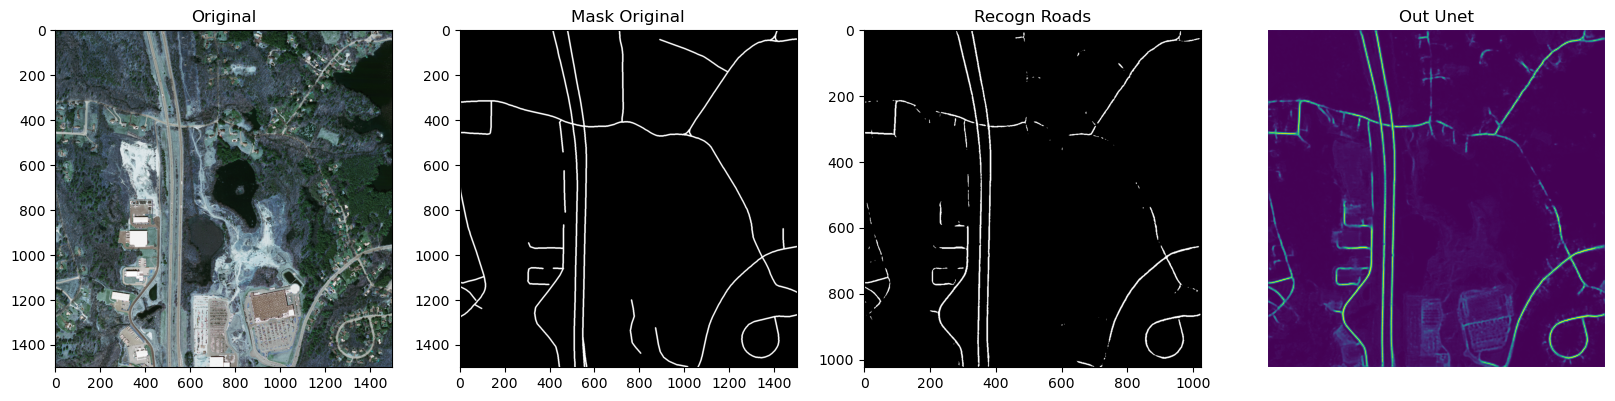

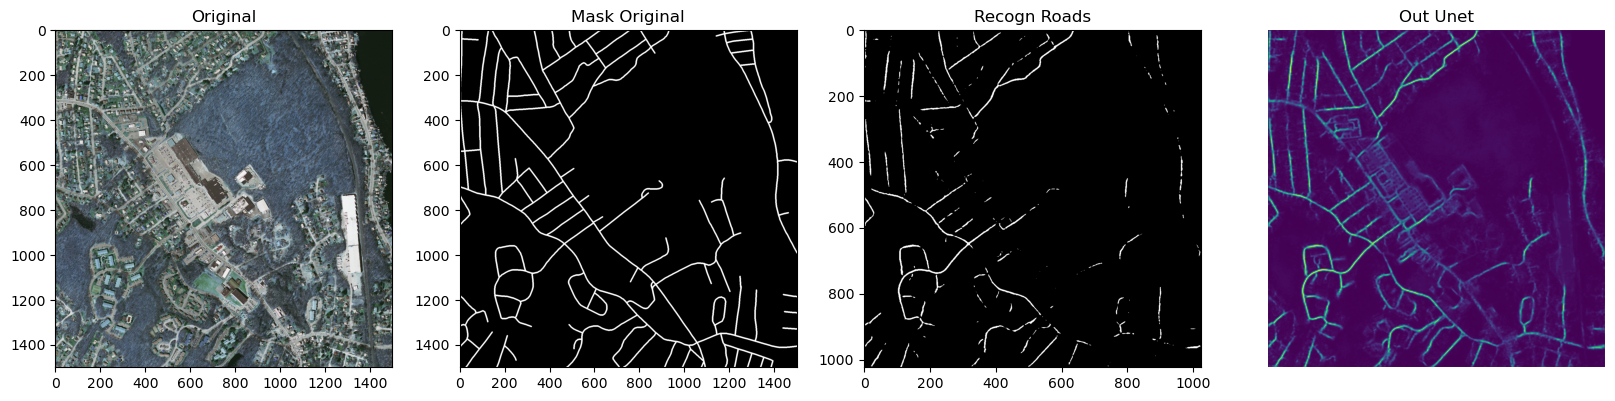

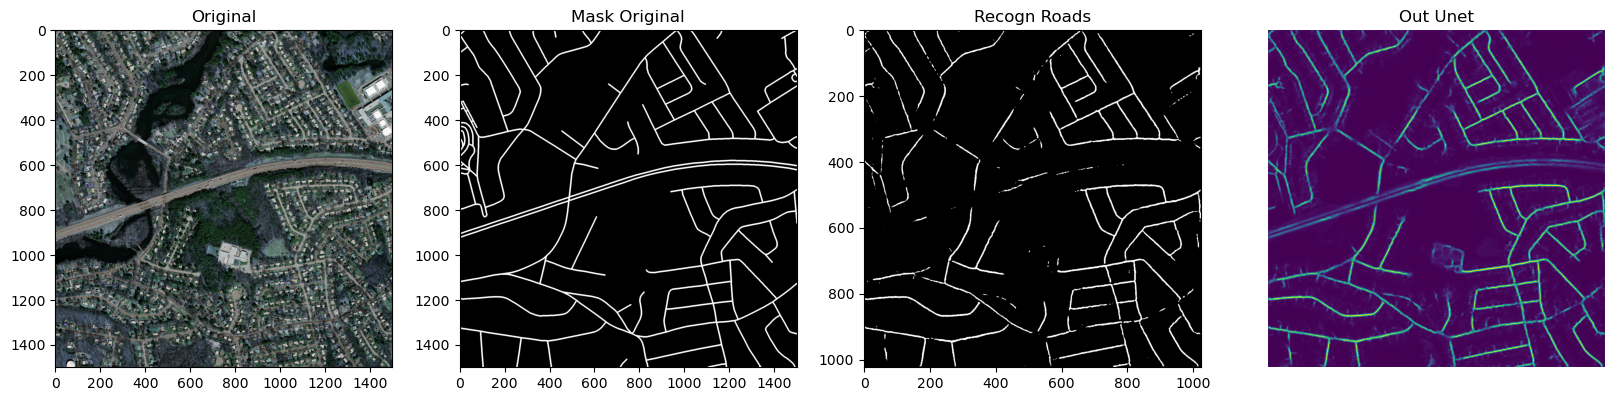

In [16]:
recogn_test_image(Perc_DS)

### Model Evaluation

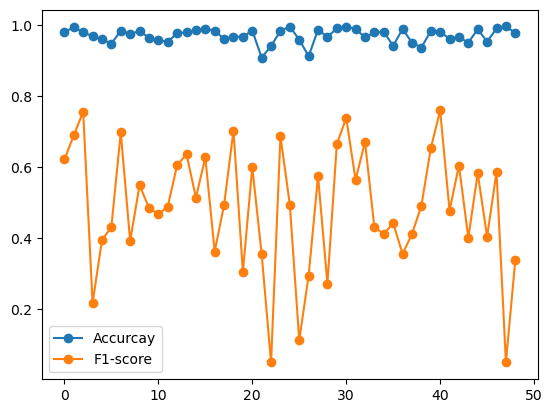

In [17]:
VAcc = [[],[]]
VF1 = [[],[]]

Perc_Test = 1

test_images = os.listdir(t_mask_dir)
nr_samples = int(len(test_images)*Perc_Test)


test_sample = random.sample(test_images, nr_samples)

for test in test_sample:
    im_test = cv2.imread(os.path.join(test_dir,test+'f'))
    mask = cv2.imread(os.path.join(t_mask_dir,test))
    im_mask = preprocess_mask_image2(mask, 2, 50)
    out_test = model.predict(prepare_test_image(im_test), verbose=0)
    img_r = binaryImage(out_test)
    

    im_mask = cv2.resize(im_mask, (out_test.shape[2], out_test.shape[1]))

    out_test_bin = (out_test > 0.5).astype(int)
    im_mask_bin = im_mask.astype(int)
    acc = accuracy_score(im_mask_bin.flatten(), out_test_bin.flatten())
    f1 = f1_score(im_mask_bin.flatten(), out_test_bin.flatten())
    
    VAcc[0].append(test+'f')
    VAcc[1].append(acc)
    VF1[0].append(test+'f')
    VF1[1].append(f1)
    

indices = range(len(VAcc[0]))


plt.plot(indices, VAcc[1], label='Accurcay', marker='o')


plt.plot(indices, VF1[1], label='F1-score', marker='o')


plt.legend()


plt.show()

In [18]:
for i,j in enumerate (VAcc[0]):
    print(str(VAcc[0][i]) + ' , ' + str(VAcc[1][i]))

18178780_15.tiff , 0.9801816940307617
15928855_15.tiff , 0.9933443069458008
18328960_15.tiff , 0.9797935485839844
22528885_15.tiff , 0.9679412841796875
22529065_15.tiff , 0.9593315124511719
24478855_15.tiff , 0.947575569152832
18478735_15.tiff , 0.9836196899414062
26578720_15.tiff , 0.9750890731811523
22228900_15.tiff , 0.9828176498413086
24479215_15.tiff , 0.9643125534057617
11128870_15.tiff , 0.9575738906860352
24628885_15.tiff , 0.9526987075805664
12328750_15.tiff , 0.9767894744873047
23878540_15.tiff , 0.9790496826171875
20278885_15.tiff , 0.9857540130615234
26878690_15.tiff , 0.9891681671142578
24779275_15.tiff , 0.9839344024658203
24479170_15.tiff , 0.9605340957641602
20878930_15.tiff , 0.9674520492553711
24029035_15.tiff , 0.9664583206176758
10378780_15.tiff , 0.9843873977661133
23429080_15.tiff , 0.9080734252929688
23729020_15.tiff , 0.9409503936767578
18328735_15.tiff , 0.9834308624267578
18028750_15.tiff , 0.9952964782714844
10828720_15.tiff , 0.9588251113891602
23278930_15.t

In [19]:
for i,j in enumerate (VF1[0]):
    print(str(VF1[0][i]) + ' , ' + str(VF1[1][i]))

18178780_15.tiff , 0.6215788036055723
15928855_15.tiff , 0.6896152990882811
18328960_15.tiff , 0.7560110548134501
22528885_15.tiff , 0.21746822477768982
22529065_15.tiff , 0.3949832586118836
24478855_15.tiff , 0.4314540734535149
18478735_15.tiff , 0.6977227130336842
26578720_15.tiff , 0.39218150087260034
22228900_15.tiff , 0.5491128406616782
24479215_15.tiff , 0.48602469542763743
11128870_15.tiff , 0.46750852833802137
24628885_15.tiff , 0.48923352590441466
12328750_15.tiff , 0.6049923718635375
23878540_15.tiff , 0.636748462199881
20278885_15.tiff , 0.5140217320580389
26878690_15.tiff , 0.6275577124868835
24779275_15.tiff , 0.36266646489104115
24479170_15.tiff , 0.49412627590000613
20878930_15.tiff , 0.7028824640671385
24029035_15.tiff , 0.30487973595272444
10378780_15.tiff , 0.6005611809198487
23429080_15.tiff , 0.35502174640347944
23729020_15.tiff , 0.050541294813996995
18328735_15.tiff , 0.6873942927057469
18028750_15.tiff , 0.49405006155108744
10828720_15.tiff , 0.11321297266210693


### Model Eval on SET 7 image

In [22]:
img_path_set7 = "/kaggle/input/test-image-output-set-7/Input.jpg"

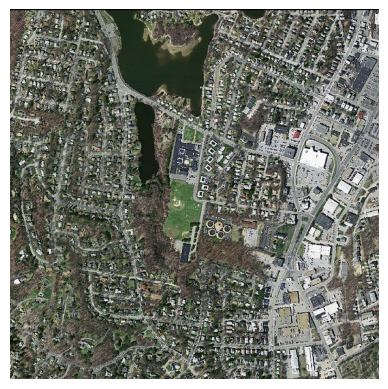

In [24]:
im_test_set7 = cv2.imread(img_path_set7)
plt.imshow(im_test_set7)
plt.axis("off")
plt.show()

In [25]:
out_test_set7 = model.predict(prepare_test_image(im_test), verbose=1)

1/1 [==============================] - 0s 26ms/step


In [26]:
img_r = binaryImage(out_test)

In [27]:
out_u = out_test[0,:, :, 0]*255

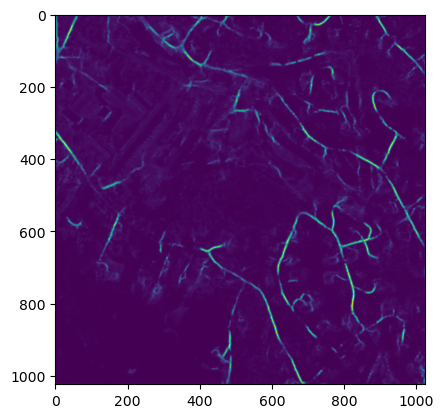

In [30]:
plt.imshow(out_u)